# This is a notebook about predicting aurora

# 0. Data Downloading

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [36]:
import calendar
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.tsatools import detrend
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.graphics.tsaplots import plot_acf, seasonal_plot, month_plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use("ggplot")
plt.rcParams.update({"font.size": 14, "axes.labelweight": "bold", "figure.figsize": (7,5), "lines.linewidth": 2})

In [2]:
# Downloading Kp Index data from https://www.gfz-potsdam.de/
from getKpindex import getKpindex

kpindex_data = getKpindex(starttime="1932-01-01", endtime=datetime.today().strftime('%Y-%m-%d'), index="Kp")

# 1. Exploratory Data Analysis

## 1.1 Data Exploration
Let's first take a look at the dataset. Clean it if necessary, and try to make sense of the data. 

In [3]:
# Since kpindex_data is a transposed 2D list or array, transpose it back to the correct format.
kpindex_data_transposed = list(zip(*kpindex_data))

# Convert to a DataFrame
kpindex_df = pd.DataFrame(kpindex_data_transposed, columns=["Datetime", "Kp_Index", "Status"])

# Convert 'Datetime' to pandas datetime object
kpindex_df['Datetime'] = pd.to_datetime(kpindex_df['Datetime'])

kpindex_df.head()

,Datetime,Kp_Index,Status
0,1932-01-01 00:00:00+00:00,3.333,def
1,1932-01-01 03:00:00+00:00,2.667,def
2,1932-01-01 06:00:00+00:00,2.333,def
3,1932-01-01 09:00:00+00:00,2.667,def
4,1932-01-01 12:00:00+00:00,3.333,def


In [4]:
# Check for any missing data
kpindex_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270864 entries, 0 to 270863
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype              
---  ------    --------------   -----              
 0   Datetime  270864 non-null  datetime64[ns, UTC]
 1   Kp_Index  270864 non-null  float64            
 2   Status    270864 non-null  object             
dtypes: datetime64[ns, UTC](1), float64(1), object(1)
memory usage: 6.2+ MB


In [5]:
# Check for missing values
kpindex_df.isnull().sum()

Datetime    0
Kp_Index    0
Status      0
dtype: int64

There is three columns in the downloaded data, corresponding to the datetime of the record, the Kp index at the time, and whether it's a recorded or predicted value. There is no missing data in the datasets, so I won't need to perform any imputation. 

In [6]:
# Let's define a function for plotting the Kp index over a specified date range. 

def plot_kp_index_by_date_range(kpindex_data, start_date=None, end_date=None):
    """
    Function to filter Kp index data by a specific date range, plot the data, and highlight the highest point.
    
    Parameters:
    kpindex_data (pd.DataFrame): The full Kp index dataset containing 'Datetime' and 'Kp_Index'.
    start_date (str, optional): The start date (inclusive) in the format 'YYYY-MM-DD'. Defaults to None, showing all data.
    end_date (str, optional): The end date (exclusive) in the format 'YYYY-MM-DD'. Defaults to None, showing all data.
    
    Returns:
    None
    """

    # Ensure 'Datetime' is in datetime format
    kpindex_data['Datetime'] = pd.to_datetime(kpindex_data['Datetime'])
    
    # Filter the data for the given date range
    if start_date and end_date:
        filtered_data = kpindex_data[(kpindex_data['Datetime'] >= start_date) & 
                                     (kpindex_data['Datetime'] < end_date)]
    else:
        filtered_data = kpindex_data

    # Check if data exists in the date range
    if filtered_data.empty:
        print("No data available for the specified date range.")
        return
    
    # Find the highest Kp index value and its corresponding time
    peak_kp_value = filtered_data['Kp_Index'].max()
    peak_kp_time = filtered_data[filtered_data['Kp_Index'] == peak_kp_value]['Datetime'].values[0]
    
    # Plot the filtered data
    plt.figure(figsize=(10, 6))
    plt.plot(filtered_data['Datetime'], filtered_data['Kp_Index'], label="Kp Index", color='blue')

    # Highlight the peak
    plt.scatter(peak_kp_time, peak_kp_value, color='red', zorder=5, label=f'Peak Kp Index ({pd.to_datetime(peak_kp_time).strftime("%Y-%m-%d %H:%M")} UTC)')

    # Annotate the peak value
    plt.text(peak_kp_time, peak_kp_value + 0.2, f"Peak: {peak_kp_value:.1f}", color='red')

    # Labels and title
    if start_date and end_date:
        title = f'Kp Index from {start_date} to {end_date} (Highlighted Peak)'
    else:
        title = 'Kp Index (Highlighted Peak for All Data)'
    
    plt.xlabel('Date')
    plt.ylabel('Kp Index')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()

    # Show the plot
    plt.show()


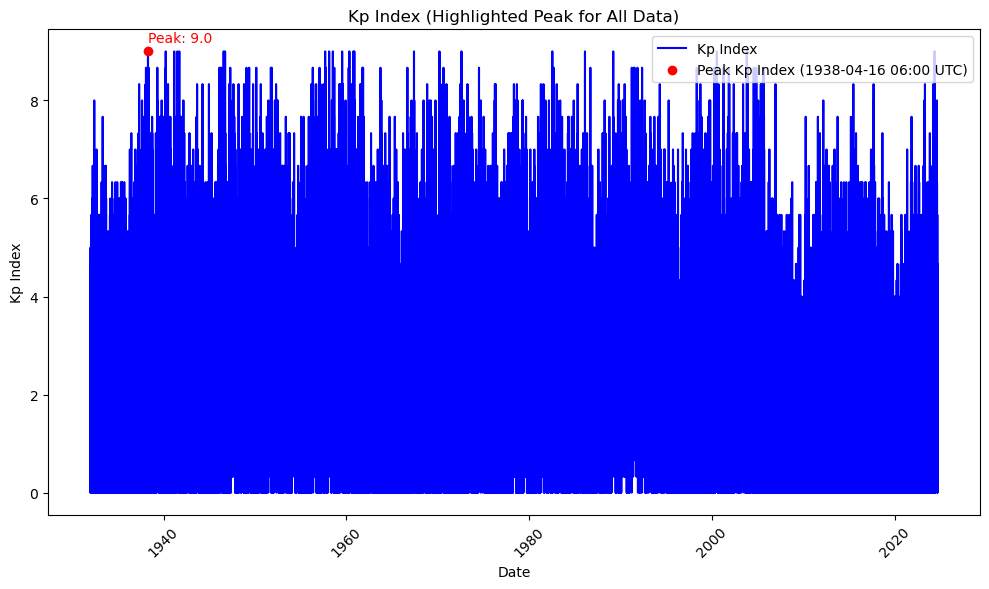

In [7]:
# To show all data:
plot_kp_index_by_date_range(kpindex_df)

This is a very large plot with many years of data. Let's look at the past month only (August 2024). 

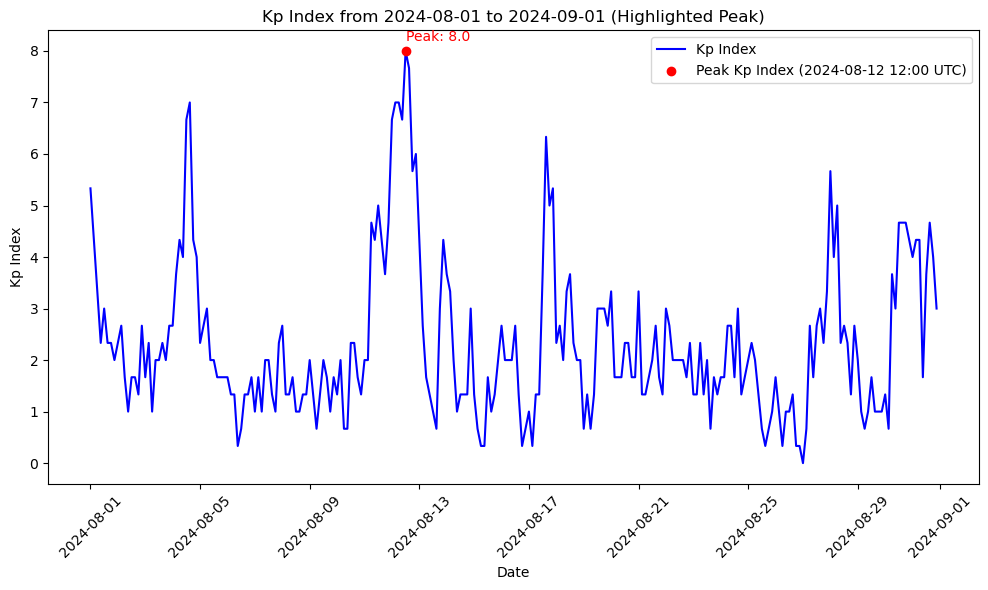

In [8]:
# To show data for August 2024:
plot_kp_index_by_date_range(kpindex_df, '2024-08-01', '2024-09-01')

The plot looks great, and I personally was able to see aurora borealis on August 12th, 2024. Which had the peak in Kp index. 

I saw another one in May 2024. Let's see if we can find it using the plot.

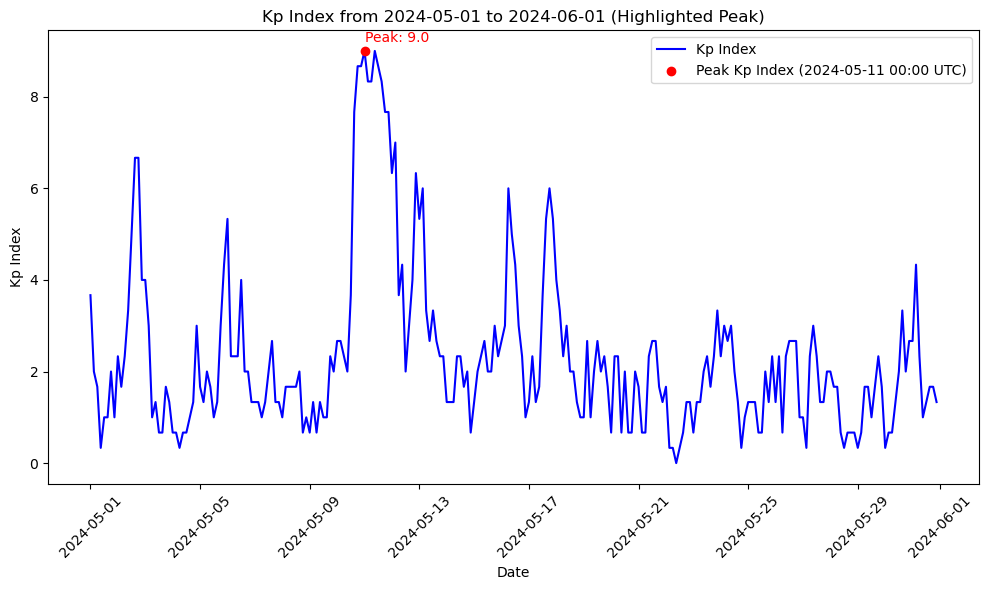

In [9]:
# To show data for August 2024:
plot_kp_index_by_date_range(kpindex_df, '2024-05-01', '2024-06-01')

What about in September 2024?

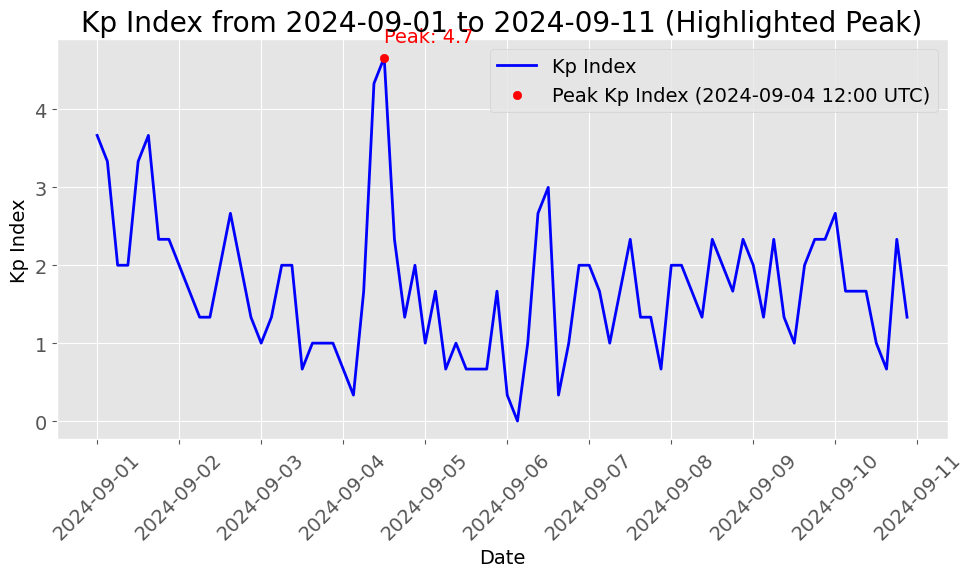

In [27]:
# To show data for August 2024:
plot_kp_index_by_date_range(kpindex_df, '2024-09-01', '2024-09-11')

## 1.2 Autocorrelation
With a lot of time-series data, there are temporal dependence, which means the value at a time is dependent on the value in the past. I will now take a look at this dependence, which is also called "autocorrelation". 

Text(0, 0.5, 'ACF')

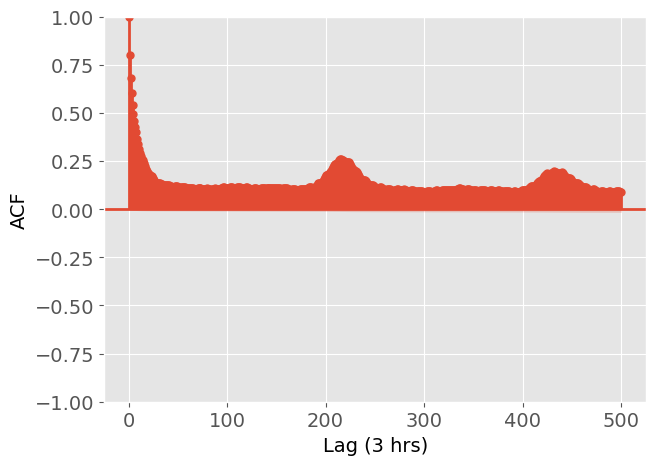

In [58]:
acf_fig = plot_acf(kpindex_df["Kp_Index"], lags=500, title=None, bartlett_confint=True)
plt.xlabel("Lag (3 hrs)")
plt.ylabel('ACF')

There seems to be a trend of autocorrelation around 220 lags (220 * 3hr = 660 hrs or 27.5 days). Maybe this is the cycle of the moon? 

Let me first get the exact lag value. 

In [59]:
acf_data = acf(kpindex_df["Kp_Index"], nlags=250, bartlett_confint=True)
acf_data[:25]

array([1.        , 0.80096554, 0.67964459, 0.60156042, 0.54181679,
       0.49477262, 0.45744336, 0.42739958, 0.39886787, 0.36652409,
       0.33701804, 0.31202083, 0.29078333, 0.27443764, 0.26312043,
       0.25317119, 0.24249425, 0.22665981, 0.20994401, 0.19687188,
       0.18729925, 0.18094721, 0.17649412, 0.17405466, 0.17082036])

In [60]:
# Create lags array
lags = np.arange(len(acf_data))

# Define the range for finding the highest point
start_lag = 50
end_lag = 250

# Find indices within the specified lag range
indices_within_range = np.where((lags >= start_lag) & (lags <= end_lag))[0]

# Find the maximum ACF value within this range
max_index = indices_within_range[np.argmax(acf_data[indices_within_range])]
max_lag = lags[max_index]
max_acf_value = acf_data[max_index]

print(f'The maximum ACF value is at lag {max_lag} with a value of {max_acf_value}.')

The maximum ACF value is at lag 216 with a value of 0.26295366052866104.


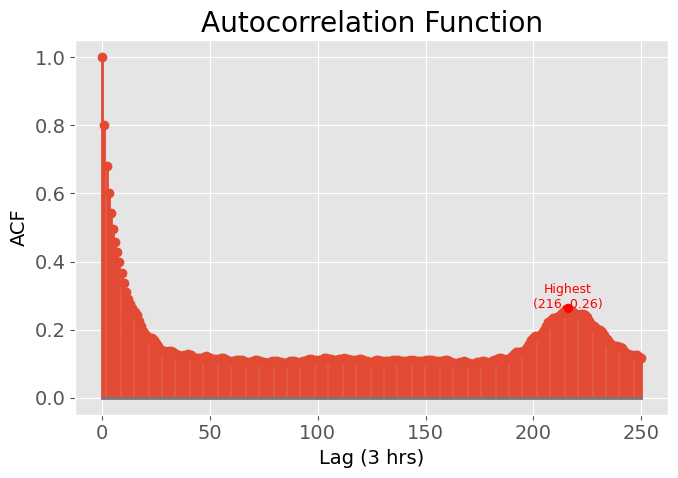

In [67]:
# Plot ACF
plt.stem(lags, acf_data, use_line_collection=True)
plt.xlabel("Lag (3 hrs)")
plt.ylabel('ACF')

# Annotate the highest point
plt.scatter(max_lag, max_acf_value, color='red', zorder=5)
plt.text(max_lag, max_acf_value, f'Highest\n({max_lag}, {max_acf_value:.2f})',
         color='red', fontsize=9, ha='center')

plt.title('Autocorrelation Function')
plt.tight_layout()
plt.show()

So there seems to be the autocorrelation at 216 x 3 hours, or 27 days. 

Let's use seasonal_decompose to remove this trend and seasonality. 

In [68]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(kpindex_df["Kp_Index"], model='additive', period=216)

# Detrended data (observed - trend)
detrended_data = kpindex_df["Kp_Index"] - result.trend

# Create a new DataFrame to hold the detrended data
kpindex_df_detrended = kpindex_df.copy()
kpindex_df_detrended["Detrended_Kp_Index"] = detrended_data

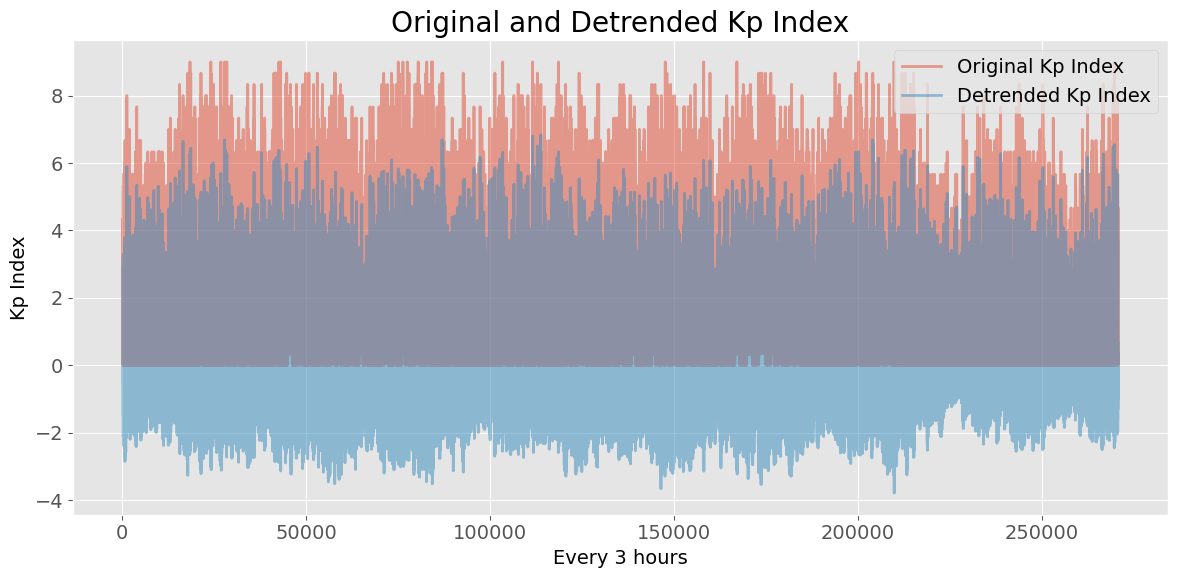

In [74]:
# Plot the original and detrended data for comparison
plt.figure(figsize=(12, 6))
plt.plot(kpindex_df.index, kpindex_df["Kp_Index"], label="Original Kp Index", alpha=0.5)
plt.plot(kpindex_df_detrended.index, kpindex_df_detrended["Detrended_Kp_Index"], label="Detrended Kp Index", alpha=0.5)
plt.xlabel("Every 3 hours")
plt.ylabel("Kp Index")
plt.title("Original and Detrended Kp Index")
plt.legend()
plt.tight_layout()
plt.show()

# Feature Engineering

To improve your forecast accuracy, we can add additional features. For example:

Rolling average of the Kp index to smooth short-term fluctuations.
Lag features (previous Kp values) to capture temporal relationships.

In [29]:
# Add rolling average for Kp_Index (e.g., 24 hours)
kpindex_df['Kp_24h_avg'] = kpindex_df['Kp_Index'].rolling(window=24).mean()

# Add lag feature (Kp value from 3 hours ago)
kpindex_df['Kp_lag_3h'] = kpindex_df['Kp_Index'].shift(3)

# Drop any rows with NaN values created by rolling or lag features
kpindex_df.dropna(inplace=True)

# Check the new features
kpindex_df.head()


,Datetime,Kp_Index,Status,Kp_24h_avg,Kp_lag_3h
69,1932-01-09 15:00:00+00:00,3.333,def,2.513833,2.667
70,1932-01-09 18:00:00+00:00,3.333,def,2.597167,3.667
71,1932-01-09 21:00:00+00:00,3.667,def,2.680500,3.333
72,1932-01-10 00:00:00+00:00,3.333,def,2.819375,3.333
73,1932-01-10 03:00:00+00:00,2.333,def,2.874917,3.333


Train-Test Split
Before you build a model, split the data into a training set (for model training) and a test set (to evaluate model performance).

In [30]:
from sklearn.model_selection import train_test_split

# Train-test split (e.g., 80% train, 20% test)
train_df, test_df = train_test_split(kpindex_df, test_size=0.2, shuffle=False)

# Verify the split
print(f"Training data length: {len(train_df)}")
print(f"Test data length: {len(test_df)}")

Training data length: 216636
Test data length: 54159
